<a href="https://colab.research.google.com/github/cu-applied-math/SciML-Class/blob/lab_solutions/Labs/lab08_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import scipy.optimize as opt

# Lab 8: solutions

We'll consider the [logistic equation](https://en.wikipedia.org/wiki/Logistic_function#In_ecology:_modeling_population_growth) for describing popluation growth.
$y(t)$ represents the population at time $t$, and satisifies the equation
$$dy/dt = \theta y \left( 1 - \frac{y}{k} \right)$$
where $\theta$ is the **growth rate** (often referred to as "r" but we'll use $\theta$ to match other conventions), and $k$ is a carrying capacity of the population.

This is a very simple first-order ODE, covered in any good undergrad ODE class, and has a closed-form solution,
$$y(t) = \frac{k}{ 1 + \frac{k-y_0}{y_0}e^{-\theta t}}$$
if $y(0) = y_0$ is the initial condition.

**Motivation for our lab**
We're observing a population of organisms and we know they evolve according to the logistic equation, and we know that they have a given carrying capacity of $k=10$.  We observe two data points:

| time | |  population |
| :--- | --- | :--- |
| $t_0$ |0 | $y_0=1$ |
| $t_1$| 2 | $y_1 = 7$ |

and our scientific question is, **what was the growth rate $\theta$**?

Our lab is divided into several parts:
- Part 1: familiarity with scipy's ODE solver
  - This should be quick
- Part 2 and 3a: work things out by hand
  - This should be pen-and-paper, and should also be fairly quick
- Part 3b: adjoint state method
  - This may take longer. This is the heart of the lab
- Part 4: root-finding
  - This is "extra". Only do this if you finish part 3b

## Part 1a: solve with an ODE solver
We want to plot the function and see what it looks like. Let's solve it with `scipy.integrate.solve_ivp` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)), starting at $t=0$ with a value of $y_0 = 1$, and using $k=10$. Solve until $t=5$ using $\theta=3$ as our "guess" for the growth rate for now.

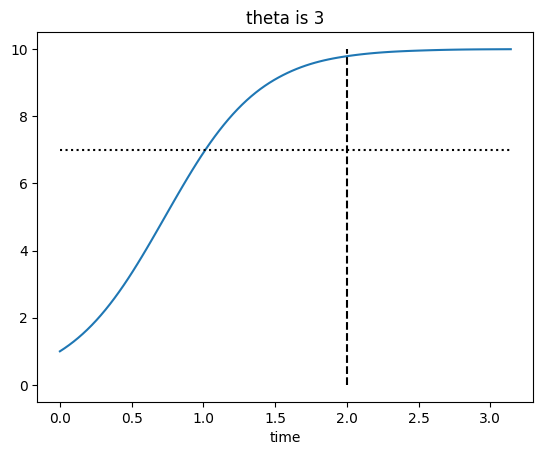

In [11]:
k = 10

def f(t,y,theta):
    """ Logistic equation right-hand-side
    dy/dt = theta y (1-y/k),  y(t) is the population, theta is growth rate parameter, k is karrying kapacity
    """
    return theta*y*(1.-y/k)

y0 = 1.
T  = 5
t_span = (0,T)
theta = 3
atol  = 1e-8

# Not necessary, but we can also make a stopping criteria:
#   we may not know a priori how long to run the ODE for, but we know
#   the carrying capacity is k, so when we're at k (steady-state), we can stop
def stop_if_close(t,y,*ignore):
    return ~( np.array(y) > k - 1e-2 )  # vectorized
stop_if_close.terminal = True

soln = solve_ivp(f,t_span, [y0], dense_output=True, args=(theta,),atol=1e-8, events=stop_if_close)
# The "dense_output"=True means that it will return a 'sol' object
#   that uses the intermediate solutions in order to represent the function y(t)
#   anywhere* we want using Hermite interpolation
# (*  it may not be very accurate outside our time domain though... )

# In case we stopped early...
t_max = soln['t'][-1]
T_max = np.minimum(t_max,T)

t1 = 2.
y1 = 7.
tGrid = np.linspace( 0, T_max, num=100 )
plt.plot( tGrid, soln['sol']( tGrid ).flatten() )
plt.plot( [0,T_max], [y1,y1], 'k:' )
plt.plot( [t1,t1], [0,k], 'k--' )
plt.xlabel('time')
plt.title(f'theta is {theta}')
plt.show()

## Part 1b: solve backward with an ODE solver

Using the final condition from part 1a (i.e., the value of $y$ at $T=5$), use the ODE solver to solve the same ODE still on the interval $[0,T]$ except give it the "final condition" rather than the initial condition.

Plot both forward and backward solutions and verify they are about the same.  *Tip: you may want to adjust `atol` and/or `rtol` in the ODE solver to get increased accuracy*

**Turn in this plot (to Canvas) with forward and backward solutions** to get credit for the lab

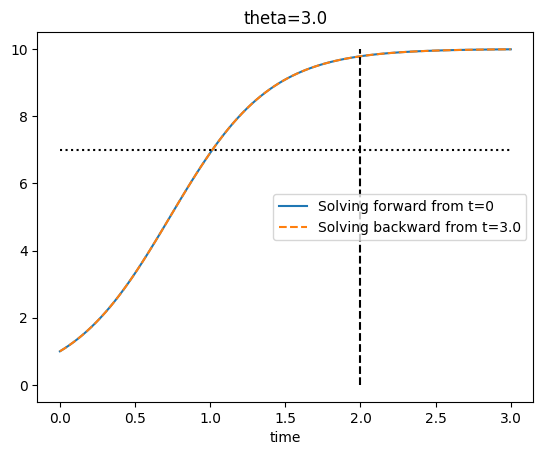

In [12]:
theta  = 3.
rtol = 1e-6 # default is 1e-3

# First, solve it forward...
y0 = 1. # Starting value
T  = 3.
soln_forward = solve_ivp(f,(0,T), [y0], dense_output=True,vectorized=True,args=(theta,),rtol=rtol)

# Now solve it backwards
yFinal = soln_forward['y'][0][-1]
tFinal = soln_forward['t'][-1]
t_span = (tFinal,0)
soln_reverse = solve_ivp(f,t_span, [yFinal], dense_output=True,vectorized=True,args=(theta,),rtol=rtol)


soln_reverse['sol']
T_max = np.minimum(t_max,T)
tGrid = np.linspace( 0, T_max, num=100 )
plt.plot( tGrid, soln_forward['sol']( tGrid ).flatten(), label='Solving forward from t=0' )
plt.plot( tGrid, soln_reverse['sol']( tGrid ).flatten(),'--',label=f'Solving backward from t={tFinal:.1f}' )
plt.plot( [0,T_max], [y1,y1], 'k:' )
plt.plot( [t1,t1], [0,k], 'k--' )
plt.title(f'theta={theta}')
plt.legend()
plt.xlabel('time')
plt.show()

## Part 2: find the right answer

Solving problems is always easier if you know the answer before you start.  In our case, we want to know what $\theta$ is. Because we have a closed-form solution for the ODE solution $y$, you can work this out by hand.

What is the correct value of $\theta$ that generates the observed data?

In [13]:
thetaTrue = -np.log( (k/y1 - 1)/( (k-y0)/y0 )  )/2
print(f'True optimal theta {thetaTrue:6.4f}')

True optimal theta 1.5223


## Part 3a: find the derivative "by hand"

Let our loss function be $\ell(\theta) = y(t_1)$, i.e., our "loss" $L$ as a function of $y(t_1)$ is simply the identity map.   We want $\frac{d\ell}{d\theta}$

(Why do we want this? Because then we could do root-finding on $\ell(\theta) = y_1$ and use Newton's method)

- Work out what $\frac{d\ell}{d\theta}$ is by hand (since we have the analytic form of $y$).

In [14]:
dydtheta = lambda theta : 180*np.exp(-2*theta)/(1+9*np.exp(-2*theta) )**2

## Part 3b: find the derivative via the adjoint state method

For more complicated ODEs without closed-form solutions, we may not be able to find the derivative "by hand", so we could use the adjoint state method.  

The point of today's lab is to practice that.

Below is the full adjoint sensitivities "Algorithm 2" from Appendix C from [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366) by Chen, Rubanova, Bettencourt and Duvenaud (NeurIPS 2018), converted to our notation ($y$ instead of $z$) and ignoring irrelevant features:

- Input dynamics parameters $\theta$, start time $t_0$, stop time $t_1$, final state $y(t_1)$, loss gradient $\frac{\partial L}{\partial y(t_1)}$
- Define initial augmented state $s_0 = [y(t_1)), \frac{\partial L}{\partial y(t_1)}, 0]$
  - The augmented variable is $s=[y,a^{(y)}, a^{(\theta)}]$ and $a$ are the adjoint quantities, $a^{(y)}(t) = \frac{dL}{dy(t)}$ and $a^{(\theta)} = \frac{dL}{d\theta}$
  - Our goal is to find $a^{(\theta)}$, e.g., at $t=t_0$, since $\theta$ is constant
  - define the fuction `augmented_dynamics`$(t,s,\theta)$
    - $s=[y,a^{(y)}, a^{(\theta)}]$
    - return $\frac{ds}{dt} = f(y(t), t, \theta), -a^{(y)}(t) \frac{\partial f}{\partial y}, -a^{(y)}(t) \frac{\partial f}{\partial \theta}]$
  - call `ODE_solver`$(s_0,$ `augmented_dynamics`$, t_1,t_0, \theta)$


Your **task** is to define appropriate dynamics and initial states to pass in to the ODE solver and solve, and then extracting the derviative. You can check with the results from part 3a

In [22]:
# Setup adjoint equation
def f(t,y,theta):
    """ Logistic equation right-hand-side
    dy/dt = theta y (1-y/k),  y(t) is the population, theta is growth rate parameter, k is karrying kapacity
    """
    return theta*y*(1.-y/k)

def dfdy(t,y,theta):
    """ df / dy """
    return theta*(1-2*y/k)
def dfdtheta(t,y,theta):
    """ df / dtheta """
    return y*(1.-y/k)

def f_adjoint(t,augmentedVariable, theta):
    """ Solve augmented adjoint equation
    """
    y         = augmentedVariable[0]
    adjoint_y = augmentedVariable[1]
    #adjoint_theta = augmentedVariable[2] # unused

    dy_dt         = f(t,y,theta) # original ODE
    dadjy_dt      = -adjoint_y * dfdy(t,y,theta)
    dadjtheta_dt  = -adjoint_y * dfdtheta(t,y,theta)

    return np.stack( (dy_dt, dadjy_dt, dadjtheta_dt) )


theta  = 3.

# First, solve it forward...
y0 = [1.] # Starting value
# T  = 3.
T  = t1  # only solve until here
soln_forward = solve_ivp(f,(0,T), y0, dense_output=True,vectorized=True,args=(theta,),rtol=rtol)

# Now, backward solve of full augmented system
yFinal = soln_forward['y'][0][-1]
yFinal = np.stack( (yFinal, 1., 0.) ) # seed adjoints
tFinal = soln_forward['t'][-1]
t_span = (tFinal,0)
soln_reverse = solve_ivp(f_adjoint,t_span, yFinal, dense_output=True,vectorized=True,args=(theta,),rtol=rtol)

print(f'Our derivative value: {soln_reverse["y"][2][-1]:.7f}')
print(f'"By hand" value:      {dydtheta(theta):.7f}')

Our derivative value: 0.4269190
"By hand" value:      0.4269150


## Part 4: root-finding to find $\theta$

### Part 4a: derivative-free method
Our unknown parameter $\theta$ is 1D, and 1D root-finding is fairly easy, even if we do not know the derivative.  Our rules-of-thumb from earlier labs is that not knowing the derivative for optimization problems is not a big deal in small dimensions, and a similar rule-of-thumb applies for root finding.

So, using a `scipy.optimize` [scalar root-finding](https://docs.scipy.org/doc/scipy/reference/optimize.html#scalar-functions) algorithm that doesn't require a derivative.
- You could do brute-force (grid search) which isn't so bad in 1D
- You can do bisection methods, or fancier variants in the `scipy.optimize` library (`root_scalar`, `brentq`, `brenth`, `bisect`, etc.).

### Part 4b: root-finding with Newton (aka Newton-Raphson)
Since we do have the derivative information (either via the adjoint-state method or using your analytic calculation), we can use Newton-Raphson (also implemented in `scipy.optimize` as `newton`).  So **use Newton-Raphson** to find $\theta$.

Note: In 1D, the main advantage of Newton-Raphson compared to bisection or other derivative-free methods is that it quickly gives you extremely high accuracy.  
- You may not always need extremely high accuracy
- The accuracy might be limited by the accuracy of your function evaluation or derivative evaluation, i.e., the accuracy of the ODE solve. If we don't solve the ODE to more than 6 digits, we shouldn't expect to find $\theta$ to 10 digits...

In [1]:
# 4a: not implemented, this is straightforward

In [16]:
# 4b:

# First, using the "by hand" value for the derivative

y2       = lambda theta : 10./(1+9*np.exp(-2*theta) )
dydtheta = lambda theta : 180*np.exp(-2*theta)/(1+9*np.exp(-2*theta) )**2

# theta = 3 # starting guess... with our simple naive Newton, it diverges
theta = 2
# We could call `scipy.optimize.newton` here, or just do it ourself
#   since it's dirt simple  (but our simple implementation doesn't have any safeguards!)
for i in range(5):
    theta -= (y2(theta)-y1)/dydtheta(theta)
    print(f'Iter {i+1:3d}, theta is {theta:6.4f}, y(t1;theta) is {y2(theta):6.4f}')


# Compare to the true value
thetaTrue = -np.log( (k/y1 - 1)/( (k-y0)/y0 )  )/2
print(f'True optimal theta {thetaTrue:6.4f}')

Iter   1, theta is 1.3477, y(t1;theta) is 6.2204
Iter   2, theta is 1.5135, y(t1;theta) is 6.9632
Iter   3, theta is 1.5222, y(t1;theta) is 6.9999
Iter   4, theta is 1.5223, y(t1;theta) is 7.0000
Iter   5, theta is 1.5223, y(t1;theta) is 7.0000
True optimal theta 1.5223


In [ ]:
# 4b, extended
# Instead of using the dydtheta "by hand" expression, use the adjoint state method
# You just need to code it up nicely...
# and then call `scipy.optimize.newton`...